# Predicting Amazon review score based only on the text
 
In this exercise I will use a Logistic regression model to explore if we can predict the score of a Book review in Amazon based exclusively on the text of the review.
 
I will begin importing the libraries necessary to perform this exercise.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pymongo import MongoClient

import re

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

client = MongoClient()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ordovas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Now we load a fraction of the dataset and visualize the head of the dataset that we obtained.

In [2]:
db = client.get_database("amazon")
# Define an alias for the books dataset
books =db.books
# Obtain a random sample from the dataset, selecting only a few records 
# (we will use only overall and reviewTest, but I will load a few more just in case I
# want to play with more info...)
res = list(books.aggregate([
    { "$sample": { "size": 60000 }}
    ,{ "$project": {"id": "$_id", "_id": 0, "overall": 1, "reviewText": 1,"summary":1,"reviewerName":1}} 
]))
# Converting to pandas DataFrame
df=pd.DataFrame(res)

In [3]:
df.head()

,overall,reviewerName,reviewText,summary,id
0,3,BMac,I read the series a long long time ago and rem...,Don't Feel That it Holds Up Well,6033ab71f7ccad4a92f17f5d
1,5,J. Schonbok,I don't know how I missed this in my youth. V...,Great YA book,6033ab95f7ccad4a92f8b088
2,4,B. Merkel,Arrived promptly and as described,Four Stars,6033ab84f7ccad4a92f53ea5
3,5,Rick K.,It's hard to pinpoint which is more impressive...,A moving exploration of family and relationships,6033ab80f7ccad4a92f470ce
4,3,Christopher Lord,This is a perfectly adequate memoir about some...,Tarnished by Hype,6033ab92f7ccad4a92f81562


I wil now drop the rows with NaN values in the `reviewText` column.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   overall       60000 non-null  int64 
 1   reviewerName  59997 non-null  object
 2   reviewText    59991 non-null  object
 3   summary       59994 non-null  object
 4   id            60000 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.3+ MB


In [5]:
df=df.dropna(subset=['reviewText'])

Let's check that everything is fine...

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59991 entries, 0 to 59999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   overall       59991 non-null  int64 
 1   reviewerName  59988 non-null  object
 2   reviewText    59991 non-null  object
 3   summary       59985 non-null  object
 4   id            59991 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.7+ MB


OK, so now I will examine the `overall` column, that is the target feature.
 
There are far more reviews with high scores than with low scores, so there is no balance. To solve this, later on I will weight the clases instead of selecting now the exact number of reviews for each score.

In [7]:
df["overall"].value_counts()

5    37712
4    12252
3     5441
2     2523
1     2063
Name: overall, dtype: int64

## Preprocessing: TF-IDF
 
I will create TF-IFD vectors for each review. TF-IDF measures the frequency of each word inside a review and compares it with the number of documents where this word appears. 
 
To begin with I will clean the review text ignoring stop words and words with less than 4 letters, as they will likely not contain much information.

In [8]:
def cleaning_review(texts):
    #Remove numbers, punctuation and lowercase everything
    res=re.sub("[^A-Za-z]+", " ", texts.lower()) 
    #Remove words with less than 4 letters
    res=re.sub(r'\b\w{1,3}\b', "", res) 
    #Remove rest of stop words
    for stopword in stopwords.words('english'): 
        sw=stopword.replace("'","")
        res=res.replace(f" {sw} "," ")
    return res



Now I will create a feature with the "cleaned" text named `review_clean`

In [9]:
df["review_clean"]=df["reviewText"]
df["review_clean"]=df["review_clean"].apply(cleaning_review)
df=df.reset_index()

And then we can now create the TF-IDF vectors for each review using `TfidfVectorizer` from  `sklearn`. We ignore words that don't appear in at least 5 reviews.

In [10]:
v = TfidfVectorizer(min_df=5)
x = v.fit_transform(df['review_clean']).toarray()
df_tfidf = pd.DataFrame(x, columns=v.get_feature_names())

Just for curiosity, let's check how many features/words the TF-IDF vectors have...

In [11]:
len(v.get_feature_names())

22348

## Logistic Regression: Predicting the scores based on the TF-IDF vectors
 
First of all, we need to split the dataset into train and test samples. I will choose 85% of the sample to train and 15% to test.
 
The TD-IFD vectors are the features used to predict the target, that is the `overall` column that stores the numeric scores.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df_tfidf, df["overall"], test_size=0.15, random_state=42)

In [13]:
len(y_train),len(y_test)

(50992, 8999)

Now it's time to use the Logistic Regression model to predict the scores of the reviews.
 
We will activate `class_weight="balanced"`, as the classes (scores) are not balanced, so if we do not weigh the classes the fit will be biased towards high scores (most populated classes).
 
This is just a very simple approach, without fine tuning anything and without checking overfitting. This is just an exercise for learning purposes.

In [14]:
clf = LogisticRegression(random_state=0,class_weight="balanced").fit(X_train, y_train)

/home/ordovas/anaconda3/envs/ironhack/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


That's it? Well, now we need to check the performance of this model...

Let's check the score of the classification model for the train and test samples

In [15]:
sc_train=clf.score(X_train, y_train)
sc_test=clf.score(X_test, y_test)
print(f"Train sample classification score: {round(sc_train,2)}")
print(f"Test sample classification score: {round(sc_test,2)}")

Train sample classification score: 0.7
Test sample classification score: 0.57


This seems just OK, but let's check an histogram to see the accuracy of the predictions by plotting the true score minus the predicted score.

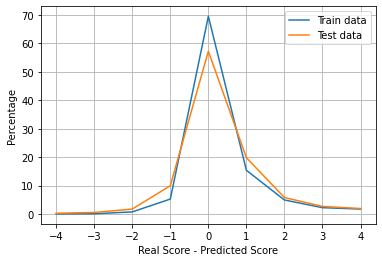

In [16]:
counts, bins = np.histogram(y_train-clf.predict(X_train),bins=np.arange(-4,6))
plt.plot(bins[:-1],counts*100/sum(counts),label="Train data")
plt.grid()
counts, bins = np.histogram(y_test-clf.predict(X_test),bins=np.arange(-4,6))
plt.plot(bins[:-1],counts*100/sum(counts),label="Test data")
plt.xlabel("Real Score - Predicted Score")
plt.ylabel("Percentage")
plt.legend();

Well, this simple model seems not to be very wrong! Let's quantify this with the confusion matrices as well.

In [17]:
confusion_matrix(y_train,clf.predict(X_train))

array([[ 1635,    41,    23,    13,    24],
       [   85,  1909,    80,    27,    36],
       [  215,   385,  3208,   467,   335],
       [  295,   466,  1334,  6248,  2097],
       [  897,   847,  1841,  6035, 22449]])

In [18]:
confusion_matrix(y_test,clf.predict(X_test))

array([[ 168,   69,   45,   20,   25],
       [  90,  126,  109,   30,   31],
       [  70,  161,  332,  186,   82],
       [  69,  104,  347,  760,  532],
       [ 175,  172,  349, 1184, 3763]])

And normalized to the true scores.

Train subsample:


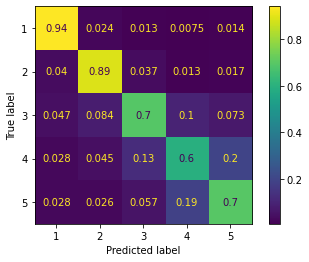

Test subsample:


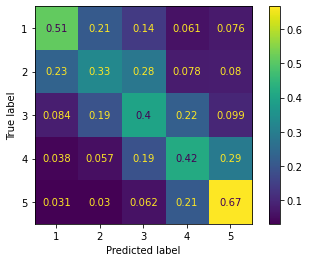

In [19]:
print("Train subsample:")
plot_confusion_matrix(clf, X_train, y_train,cmap="viridis",normalize="true") 
plt.show();
print("Test subsample:")
plot_confusion_matrix(clf, X_test, y_test,cmap="viridis",normalize="true")
plt.show();

The diagonal indicates that the Logistic Model predicts reasonably well the score of the review for this simple approach.

## Undersanding the Logistic Regression: How it is pedicted

I will create a DataFrame with the coefficients of each score to understand how the features (words) contributes to each class.

In [20]:
model=pd.DataFrame(clf.coef_,columns=X_train.columns)
model=model.T
model.columns=["1","2","3","4","5"]
model.head(20)

,1,2,3,4,5
aaron,0.143835,0.116072,-0.134834,-0.190633,0.065560
aback,-0.100436,-0.179772,0.334148,-0.079878,0.025938
abandon,-0.190054,0.407521,-0.355912,0.040815,0.097630
abandoned,0.449588,1.293238,-0.825934,-0.545824,-0.371069
abandoning,0.987977,-0.510773,-0.290151,-0.241187,0.054134
abandonment,-0.224157,-0.042891,0.146707,0.030791,0.089550
abandons,0.169398,0.178445,-0.006686,-0.241509,-0.099648
abarat,0.022617,-0.141684,0.052952,-0.212523,0.278638
abba,-0.009111,-0.003449,-0.004060,-0.006977,0.023597
abbey,-0.533187,1.025832,-0.169082,-0.398923,0.075359


For the highest score, the words that are directly correlated and contributes the most are words as "excellent", "great", "love", "fantastic", "amazing"...

In [21]:
model["5"].sort_values(ascending=False).head(20)

excellent      4.104869
highly         4.019691
loved          3.772872
fantastic      3.624823
perfect        3.607589
great          3.590490
amazing        3.545597
love           3.460117
wait           3.146633
awesome        2.815119
wonderful      2.810521
loves          2.751754
must           2.605154
beautiful      2.573566
incredible     2.548318
beautifully    2.471592
brilliant      2.456229
always         2.351880
powerful       2.285517
wonderfully    2.283643
Name: 5, dtype: float64

So, for the lowest score, it is not strange that the words that are directly correlated and contribute the most are words such as "terrible","trash" or "boring".

In [22]:
model["1"].sort_values(ascending=False).head(20)

waste            6.193684
boring           4.869914
worst            4.856688
awful            4.750948
money            4.636627
ridiculous       4.418359
terrible         4.292857
poorly           4.005158
stupid           3.753875
ruined           3.742148
worse            3.633837
disappointing    3.628819
hated            3.611084
horrible         3.448737
garbage          3.366998
zero             3.210676
painful          3.068765
trash            3.053153
unreadable       3.038674
downhill         2.984787
Name: 1, dtype: float64

With respect to the intermediate scores, the words that define these reviews are related to texts that show good and bad aspects of the product, so words like "however" or "unfortunately" are weighted high, as well as "okay","somewhat" and "alright".

In [23]:
model["3"].sort_values(ascending=False).head(20)

however          3.259233
somewhat         2.732114
still            2.620335
okay             2.588442
stars            2.346963
ultimately       2.310518
felt             2.304861
alright          2.302371
unfortunately    2.294892
expecting        2.225591
overall          2.214540
parts            2.075353
frames           2.047367
said             1.970954
pleasant         1.940670
places           1.934693
sunday           1.910769
lacking          1.909325
trouble          1.879527
situations       1.871509
Name: 3, dtype: float64

On the other side, words with the lowest value of the coefficients show other information: features that are least likely to appear on a review. For instance, for the best reviewed books, we will not find words as "boring" or "disappointing".

In [24]:
model["5"].sort_values(ascending=True).head(20)

boring          -4.533496
disappointing   -4.429370
instead         -3.888740
disappointed    -3.615691
unfortunately   -3.579774
okay            -3.523025
however         -3.402271
tedious         -3.270153
worst           -3.208014
maybe           -3.188041
seemed          -3.029942
slow            -2.998665
waste           -2.964775
seems           -2.940699
predictable     -2.829754
nothing         -2.794211
depressing      -2.766110
rather          -2.540052
pages           -2.525732
awful           -2.507709
Name: 5, dtype: float64

For the products with lowest score, we will not find "perfect", "good", "enjoyed" or "great".

In [25]:
model["1"].sort_values(ascending=True).head(20)

stars        -4.195903
makes        -4.173993
feeling      -3.619717
overall      -3.354982
good         -3.314340
still        -3.247468
society      -3.208570
sometimes    -3.176106
glad         -2.944090
perfect      -2.934790
today        -2.933464
best         -2.909652
enjoyed      -2.899989
turner       -2.893513
great        -2.834244
parts        -2.747630
definitely   -2.699242
weeks        -2.694500
wait         -2.610092
important    -2.604519
Name: 1, dtype: float64

Lastly, for scores as 3, we will not find words that indicate extreme (good or bad) reviews. So features like "wonderful" and "waste" have low weights.

In [26]:
model["3"].sort_values(ascending=True).head(20)

anyone       -2.847533
waste        -2.616589
wonderful    -2.571549
totally      -2.453926
thoroughly   -2.392370
highly       -2.185900
page         -2.134594
awesome      -2.055848
seriously    -2.042596
truly        -2.029379
dogs         -1.934977
amazing      -1.900212
ruined       -1.857440
what         -1.796636
even         -1.792192
daniel       -1.780729
perfect      -1.739641
wait         -1.723293
absolute     -1.718998
zero         -1.716197
Name: 3, dtype: float64

## Caveats

This is a very simple approach to understand this exercise, so we can improve it a lot. We can reduce the dimensionality of the features using PCA, test different algorithms and tune the ML parameters. But in this notebook I show this simple solution to learn how it works.